In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import metrics 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

In [ ]:
PATH = './'
FILENAME = 'Crop_recommendation.csv'
data = pd.read_csv(PATH+FILENAME)

In [ ]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [ ]:
# for which crops do we have data
crop_names = data['label'].unique()
print(crop_names)

# how many types of crops are there in the dataset
print(data['label'].unique().shape)

['rice' 'pomegranate' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'maize' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']
(22,)


In [ ]:
# how many data points do we have per crop
data['label'].value_counts()

coffee         100
blackgram      100
orange         100
watermelon     100
kidneybeans    100
muskmelon      100
maize          100
lentil         100
rice           100
grapes         100
mungbean       100
cotton         100
mothbeans      100
jute           100
chickpea       100
coconut        100
papaya         100
mango          100
pomegranate    100
pigeonpeas     100
banana         100
apple          100
Name: label, dtype: int64

In [ ]:
# do we have missing data
data.isnull().sum()
# nope, all good!

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [ ]:
# let's introduce more meaningful labels 
data.rename(columns={'N':'nitrogen','P':'phosphorus','K':'potassium','label':'crop'}, inplace=True)
data.head()

,nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
# create variables that define what our dependent and independent variables are
features = ['nitrogen','phosphorus','potassium','temperature','humidity','ph','rainfall']
target = ['crop']
# let's split the data up into features and labels
X = data[features]
y = data[target]

In [ ]:
# TRAINING AND TESTING DATA
# test size defaults to 25% of whole dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.33)

In [ ]:
# DATA PREPROCESSING
for ii, col in enumerate(features):
  print('{} (min,max): \t \t {:.2f} {:.2f}'.format(col,data[col].min(),data[col].max()))

nitrogen (min,max): 	 	 0.00 140.00
phosphorus (min,max): 	 	 5.00 145.00
potassium (min,max): 	 	 5.00 205.00
temperature (min,max): 	 	 8.83 43.68
humidity (min,max): 	 	 14.26 99.98
ph (min,max): 	 	 3.50 9.94
rainfall (min,max): 	 	 20.21 298.56


In [ ]:
# scale inputs. It's important that we apply the scaling after splitting data into training and test
# Otherwise, we would introduce a bias in the training, as the scaling would depend on the test data which 
# in practice is not available during training
mmscaler = MinMaxScaler() 
X_train = mmscaler.fit_transform(X_train)
X_test = mmscaler.transform(X_test)
# convert labels to numerical values 
y_train = LabelEncoder().fit_transform(np.asarray(y_train).ravel())
y_test = LabelEncoder().fit_transform(np.asarray(y_test).ravel())

In [ ]:
for ii, col in enumerate(features):
  print('{} (min,max): \t \t {:.2f} {:.2f}'.format(col,X_train[:,ii].min(),X_train[:,ii].max()))

nitrogen (min,max): 	 	 0.00 1.00
phosphorus (min,max): 	 	 0.00 1.00
potassium (min,max): 	 	 0.00 1.00
temperature (min,max): 	 	 0.00 1.00
humidity (min,max): 	 	 0.00 1.00
ph (min,max): 	 	 0.00 1.00
rainfall (min,max): 	 	 0.00 1.00


In [ ]:
# TRAINING THE ALGORITHM
# define our model. This is a one-liner, thanks to the powerful machine learning library scikit-learn.
model = RandomForestClassifier()
# fit the model to the training data 
model.fit(X_train,y_train)
# get predictions on the test data 
y_pred=model.predict(X_test)
# print training and test accuracy
print('Training Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_train,model.predict(X_train))*100,metrics.accuracy_score(y_test,model.predict(X_test))*100))

Training Accuracy: 100.00%, Test Accuracy: 99.72%


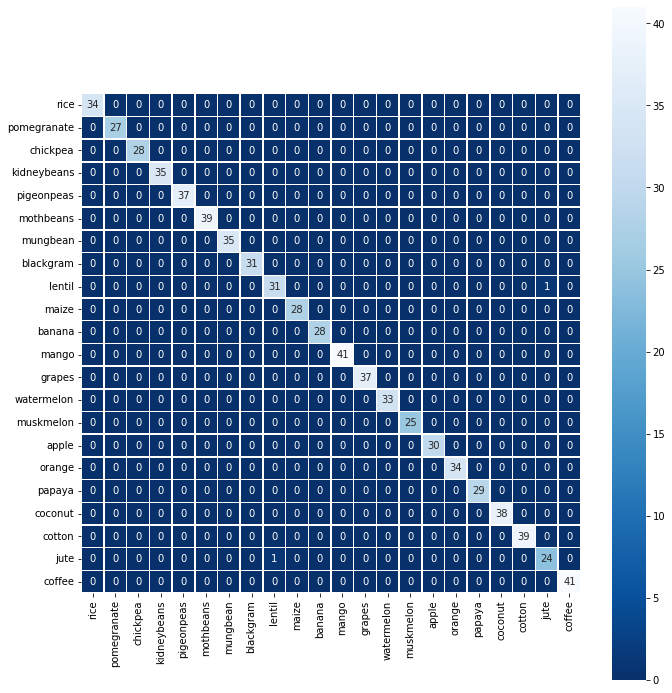

In [ ]:
# EVALUATING ALGORITHM
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred=model.predict(X_test)
metrics.accuracy_score(y_test,y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_pred,y_test),square=True,cmap='Blues_r',annot=True,fmt=".0f",linewidths=.5)
ax = plt.gca()
_ = ax.set_xticklabels(crop_names,rotation='vertical')
_ = ax.set_yticklabels(crop_names,rotation='horizontal')
plt.tight_layout()


In [ ]:
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        37
           5       1.00      1.00      1.00        39
           6       1.00      1.00      1.00        35
           7       1.00      1.00      1.00        31
           8       0.97      0.97      0.97        32
           9       1.00      1.00      1.00        28
          10       1.00      1.00      1.00        28
          11       1.00      1.00      1.00        41
          12       1.00      1.00      1.00        37
          13       1.00      1.00      1.00        33
          14       1.00      1.00      1.00        25
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00        34
          17       1.00    

Training Accuracy: 88.06%, Test Accuracy: 88.57%
there are 100 trees in the forest


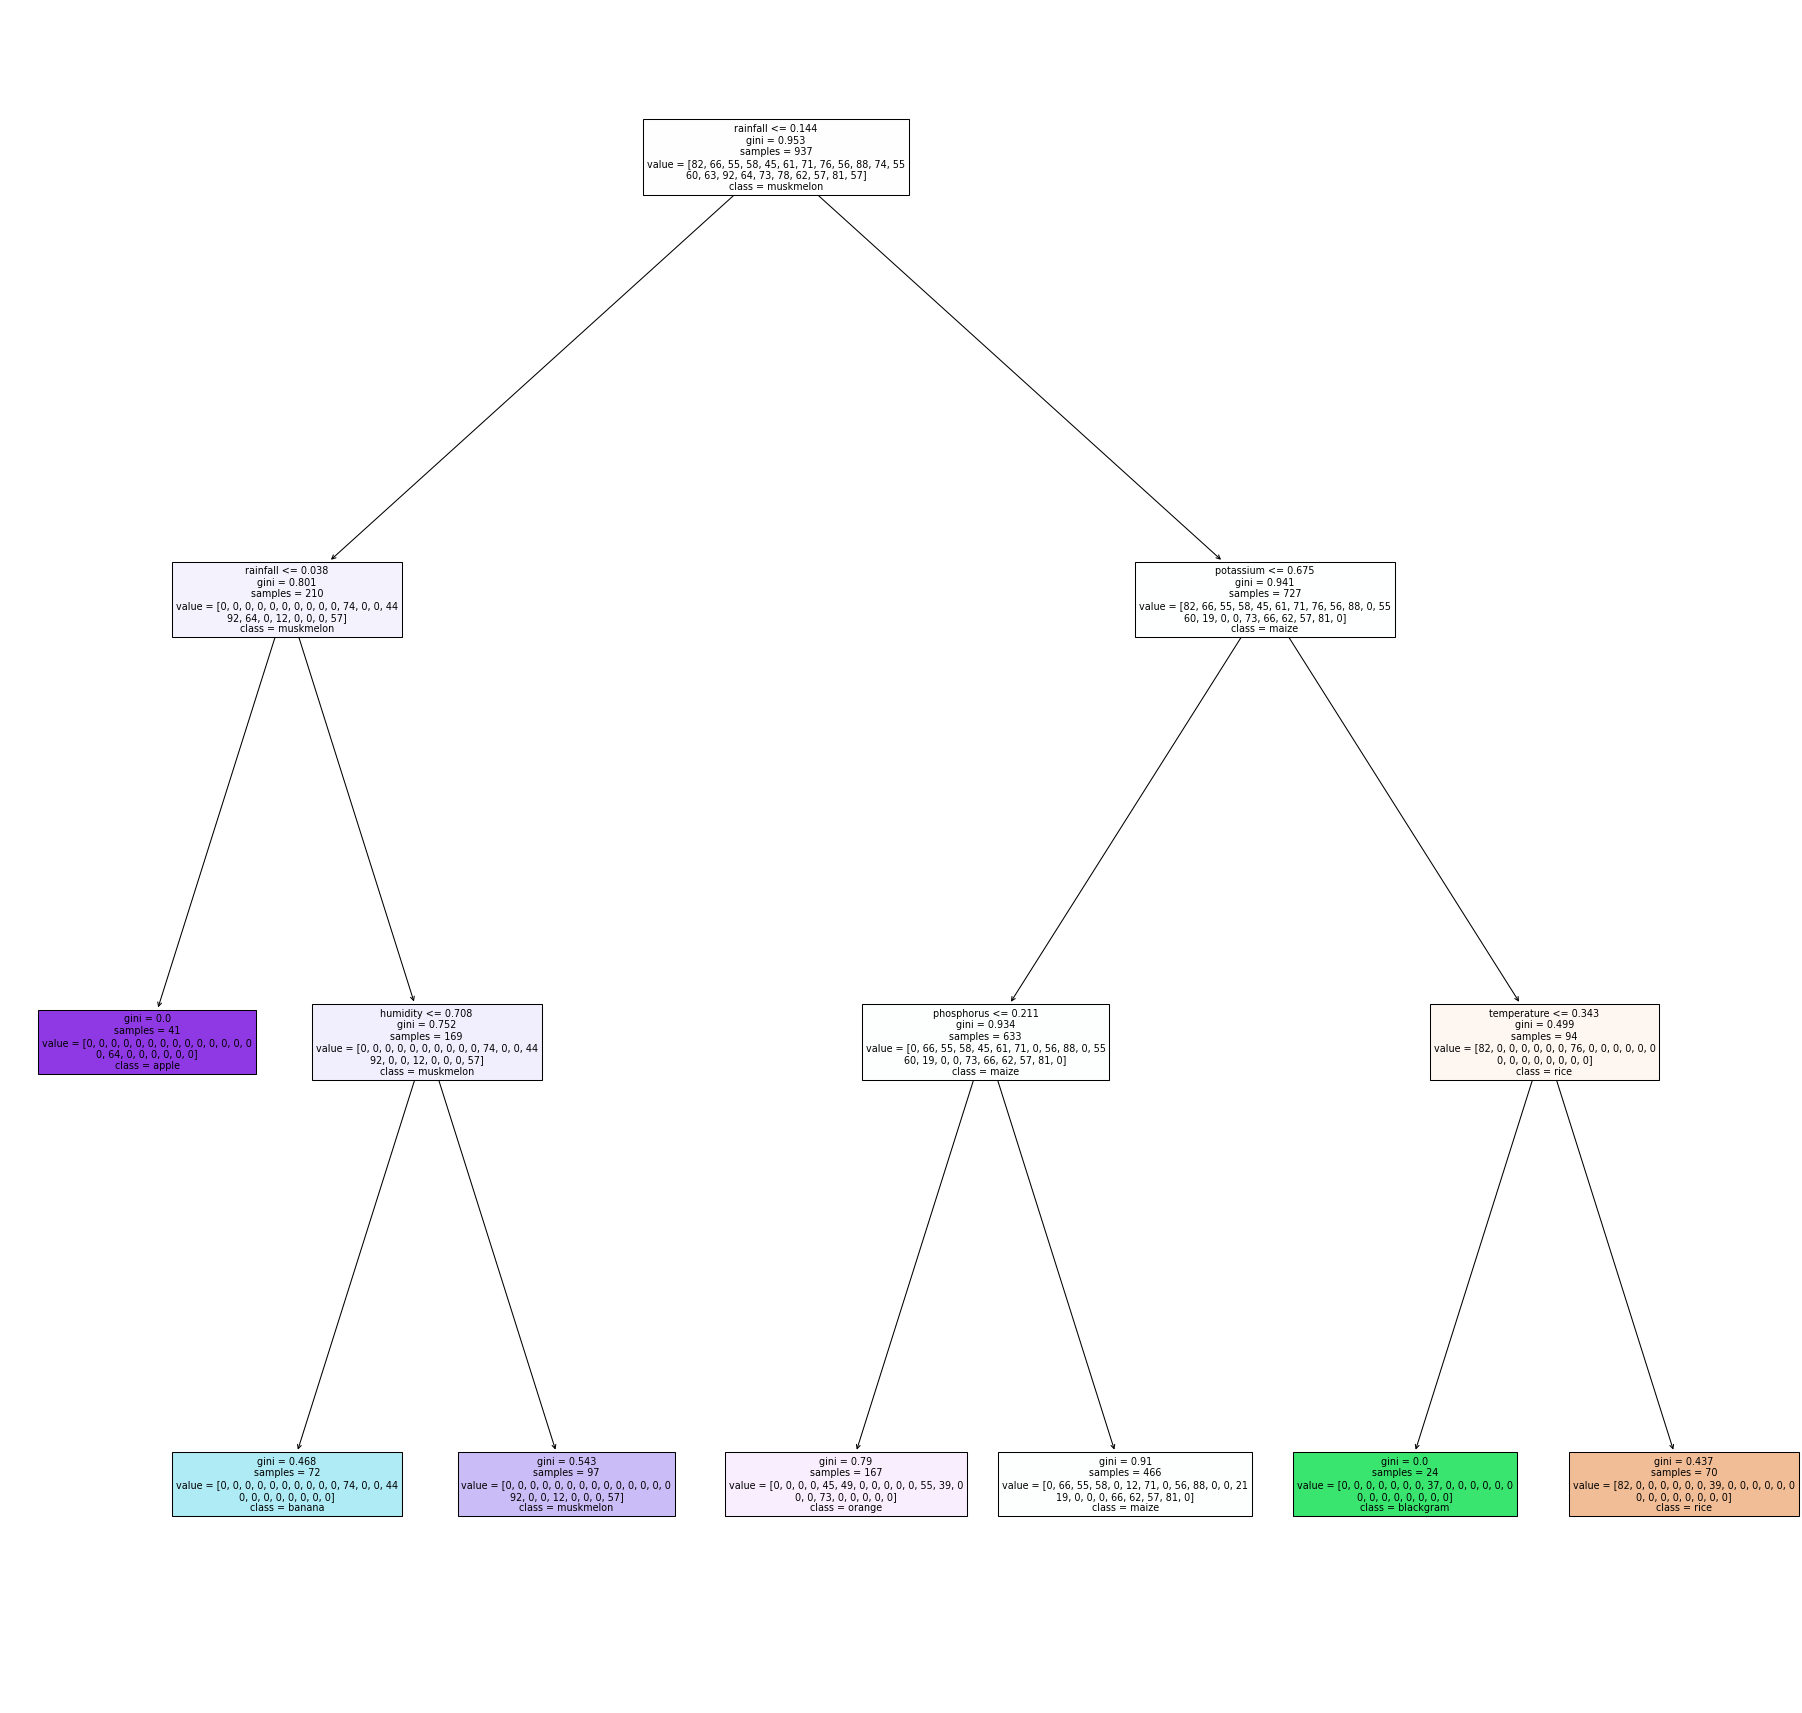

In [ ]:
from sklearn import tree

# fit a smaller forest with a maximum depth of 3 (this is how many consecutive 
# decision the algorithm can make). As a consequence, the accuracy will be lower
# but it'll be easier to visualise it
small_rf = RandomForestClassifier(max_depth=3)
# fit the forest to the training data 
small_rf.fit(X_train,y_train)
# get predictions on the test data 
y_pred=small_rf.predict(X_test)
# print training and test accuracy
print('Training Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_train,small_rf.predict(X_train))*100,metrics.accuracy_score(y_test,small_rf.predict(X_test))*100))


# obtain list of decision trees
trees = small_rf.estimators_
# how many are there
print('there are {n} trees in the forest'.format(n=len(trees)))

# visualise the first tree 
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,30),dpi=75)
tree.plot_tree(trees[0],
               feature_names = features, 
               class_names=crop_names,
               filled = True);

In [ ]:
import ipywidgets as widgets

In [ ]:
def get_predictions(x1,x2,x3,x4,x5,x6,x7):
    feature = mmscaler.transform(np.asarray([x1,x2,x3,x4,x5,x6,x7]).reshape((1,-1)))
    croptoplant = crop_names[model.predict(feature).item()]
    print('{} should grow very well under these conditions'.format(croptoplant.upper()))

In [ ]:
N = widgets.FloatSlider(min=0.0, max=140.0, value=25.0, step=2.5, description="Nitrogen")
P = widgets.FloatSlider(min=5.0, max=145.0, value=25.0, step=2.5, description="Phosphorus")
K = widgets.FloatSlider(min=5.0, max=205.0, value=25.0, step=2.5, description="Potassium")
temp = widgets.FloatSlider(min=10.0, max=44.0, value=25.0, step=2.5, description="Temperature")
hum = widgets.FloatSlider(min=15.0, max=99.0, value=25.0, step=2.5, description="humidity")
ph = widgets.FloatSlider(min=3.5, max=9.9, value=5.0, step=.5, description="pH")
rain = widgets.FloatSlider(min=20.0, max=298.0, value=25.0, step=2.5, description="Rainfall (mm)")
    
im = widgets.interact_manual(get_predictions,x1=N,x2=P,x3=K,x4=temp,x5=hum,x6=ph,x7=rain)
_ = im.widget.children[-2].description = 'GET PREDICTION'
_ = im.widget.children[-2].style.button_color='lightblue'

display(im)

interactive(children=(FloatSlider(value=25.0, description='Nitrogen', max=140.0, step=2.5), FloatSlider(value=…

<function __main__.get_predictions>

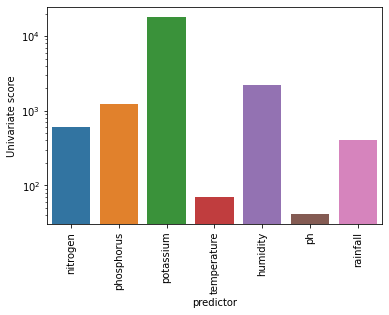

In [ ]:
# feature selection
selector = SelectKBest(score_func=f_classif,k='all')
X_train_kbest = selector.fit_transform(X_train,np.asarray(y_train).ravel())
scores = selector.scores_


X_test_kbest = selector.transform(X_test)
mask = selector.get_support() #list of booleans
new_features = [] 
scores = scores[mask==True]
for bool, feature in zip(mask, features):
    if bool:
        new_features.append(feature)
        
_ = sns.barplot(x=new_features,y=scores,log=True)
plt.ylabel('Univariate score')
plt.xlabel('predictor' )
_= plt.xticks(ticks=np.arange(X_train_kbest.shape[-1]),labels=new_features,rotation='vertical')

In [ ]:
selector = SelectKBest(score_func=f_classif,k=5)
X_train_kbest = selector.fit_transform(X_train,np.asarray(y_train).ravel())
scores = selector.scores_


X_test_kbest = selector.transform(X_test)
mask = selector.get_support() #list of booleans
new_features = [] 
scores = scores[mask==True]
for bool, feature in zip(mask, features):
    if bool:
        new_features.append(feature)

# check if it dropped temperature and ph        
print(new_features)

# run training and test on reduced dataset 
model_reduced = RandomForestClassifier()
model_reduced.fit(X_train[:,mask],y_train)

# print training and test accuracy
print('all features: Training Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_train,model.predict(X_train))*100,metrics.accuracy_score(y_test,model.predict(X_test))*100))
print('fewer features: Training Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_train,model_reduced.predict(X_train[:,mask]))*100,metrics.accuracy_score(y_test,model_reduced.predict(X_test[:,mask]))*100))

['nitrogen', 'phosphorus', 'potassium', 'humidity', 'rainfall']
all features: Training Accuracy: 100.00%, Test Accuracy: 99.72%
fewer features: Training Accuracy: 100.00%, Test Accuracy: 99.59%


In [ ]:
# comparision of different classifiers
models = []
models.append(('LogisticRegression',LogisticRegression(max_iter=5000)))
models.append(('DecisionTreeClassifier',DecisionTreeClassifier()))
models.append(('XGBClassifier',XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')))
models.append(('GradientBoostingClassifier',GradientBoostingClassifier()))
models.append(('RandomForestClassifier',RandomForestClassifier()))
models.append(('KNeighborsClassifier',KNeighborsClassifier()))
models.append(('GaussianNB',GaussianNB()))
models.append(('SVM',SVC()))

# same as above, but in cross-validation
nfolds = 5
print('{} fold cv'.format(nfolds))
X_cv = np.asarray(X)
y_cv = LabelEncoder().fit_transform(np.asarray(y).ravel())

for name,model in models:
    # apply transformation to each individual fold
    pipeline = Pipeline([('transformer', MinMaxScaler()), ('estimator', model)])    
    scores = cross_val_score(pipeline, X_cv,y_cv , cv=nfolds)
    print(name, np.round(scores.mean(),3))

5 fold cv
LogisticRegression 0.94
DecisionTreeClassifier 0.987
XGBClassifier 0.99
GradientBoostingClassifier 0.99
RandomForestClassifier 0.994
KNeighborsClassifier 0.98
GaussianNB 0.995
SVM 0.983
